In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn as nn
import copy

import matplotlib.pyplot as plt
import numpy as np



# 1.

In [2]:
train_data = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

test_data = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)


100%|██████████| 9912422/9912422 [00:00<00:00, 120732926.33it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106727483.55it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46851823.68it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23317660.67it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [3]:
train_data, valid_data = train_test_split(train_data, test_size=0.2, shuffle=True)
print('# of train data : {}'.format(len(train_data)))
print('# of valid data : {}'.format(len(valid_data)))
print('# of test data : {}'.format(len(test_data)))


# of train data : 48000
# of valid data : 12000
# of test data : 10000


In [4]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)


In [7]:
n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch



In [8]:
# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


[1/10]
training loss : 0.420	 training accuracy : 0.855
validation loss : 0.176	 validation accuracy : 0.946
validation accuracy improved 0.00000 ======> 0.94625
[2/10]
training loss : 0.157	 training accuracy : 0.954
validation loss : 0.157	 validation accuracy : 0.954
validation accuracy improved 0.94625 ======> 0.95425
[3/10]
training loss : 0.148	 training accuracy : 0.959
validation loss : 0.154	 validation accuracy : 0.960
validation accuracy improved 0.95425 ======> 0.95983
[4/10]
training loss : 0.144	 training accuracy : 0.961
validation loss : 0.164	 validation accuracy : 0.957
[5/10]
training loss : 0.144	 training accuracy : 0.961
validation loss : 0.150	 validation accuracy : 0.962
validation accuracy improved 0.95983 ======> 0.96225
[6/10]
training loss : 0.132	 training accuracy : 0.966
validation loss : 0.156	 validation accuracy : 0.962
[7/10]
training loss : 0.123	 training accuracy : 0.968
validation loss : 0.151	 validation accuracy : 0.963
validation accuracy impro

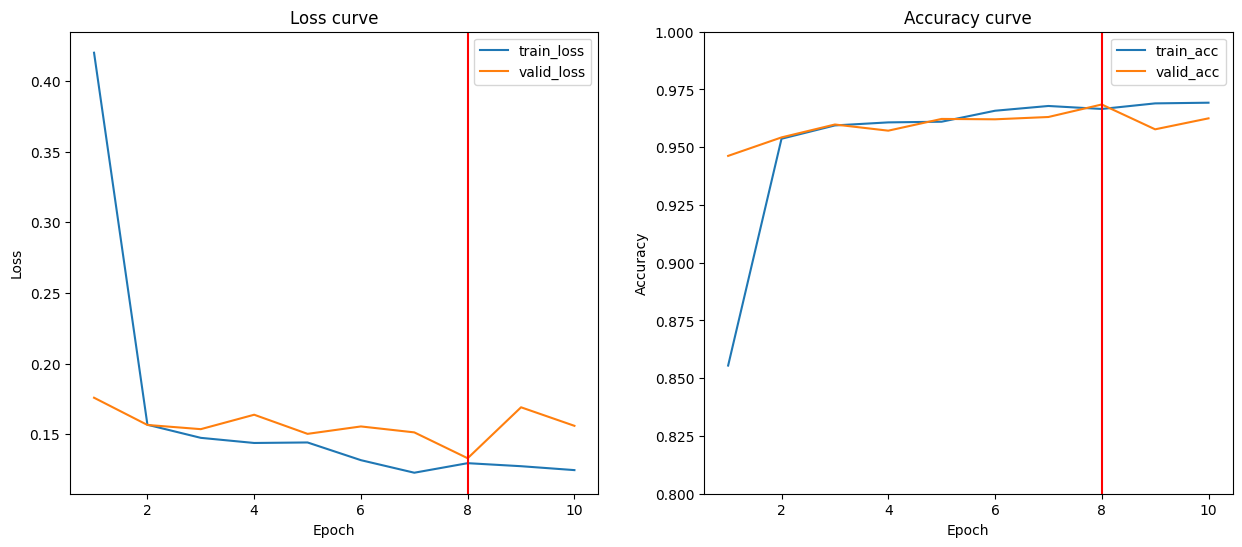

In [9]:
np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()

In [10]:
model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


test accuracy : 0.963


**1) [3 pts] change the current kernel size of the program to different size. (Change ‘kernel_size’
parameter of ‘Conv2D’ function.) Repeat this three times and compare the results.**

> Kernel Size = 10

In [11]:
batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 10)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)


In [13]:
n_epochs = 10

train_loss = [] # tr**1) [3 pts] change the current kernel size of the program to different size. (Change ‘kernel_size’
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch



In [14]:
# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

[1/10]
training loss : 0.262	 training accuracy : 0.922
validation loss : 0.142	 validation accuracy : 0.963
validation accuracy improved 0.00000 ======> 0.96250
[2/10]
training loss : 0.165	 training accuracy : 0.957
validation loss : 0.158	 validation accuracy : 0.956
[3/10]
training loss : 0.157	 training accuracy : 0.961
validation loss : 0.165	 validation accuracy : 0.960
[4/10]
training loss : 0.156	 training accuracy : 0.963
validation loss : 0.182	 validation accuracy : 0.955
[5/10]
training loss : 0.135	 training accuracy : 0.967
validation loss : 0.160	 validation accuracy : 0.960
[6/10]
training loss : 0.150	 training accuracy : 0.966
validation loss : 0.210	 validation accuracy : 0.953
[7/10]
training loss : 0.130	 training accuracy : 0.971
validation loss : 0.198	 validation accuracy : 0.953
[8/10]
training loss : 0.151	 training accuracy : 0.968
validation loss : 0.175	 validation accuracy : 0.965
validation accuracy improved 0.96250 ======> 0.96492
[9/10]
training loss :

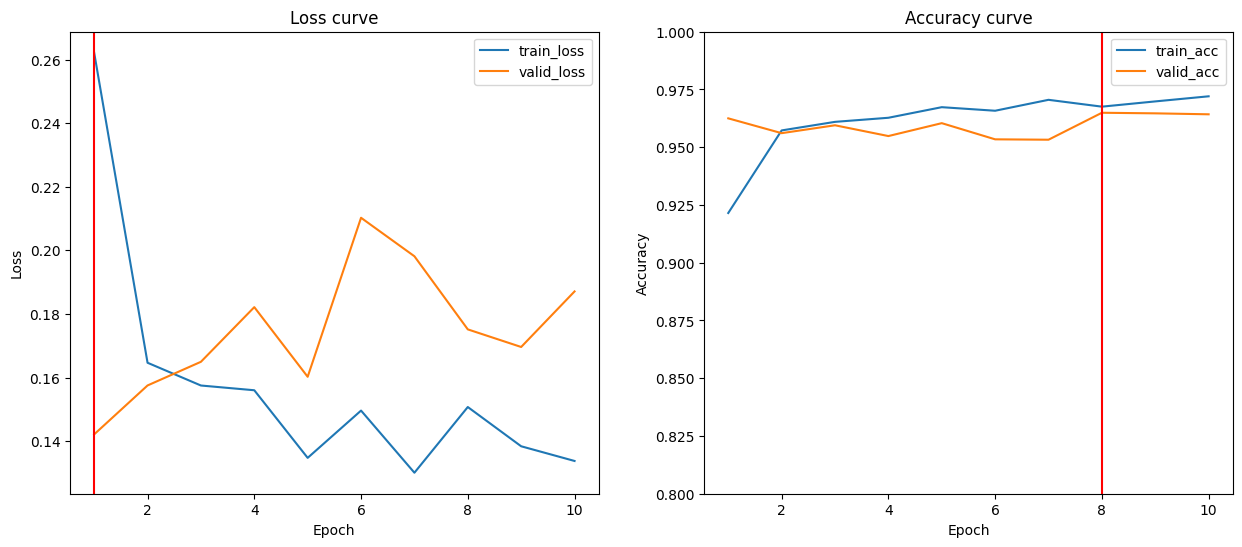

In [15]:
np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()

> Kernel Size = 6

In [16]:
batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 6)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


In [17]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)


In [18]:
n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch



In [19]:
# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

[1/10]
training loss : 0.194	 training accuracy : 0.944
validation loss : 0.111	 validation accuracy : 0.969
validation accuracy improved 0.00000 ======> 0.96925
[2/10]
training loss : 0.123	 training accuracy : 0.969
validation loss : 0.111	 validation accuracy : 0.976
validation accuracy improved 0.96925 ======> 0.97575
[3/10]
training loss : 0.124	 training accuracy : 0.971
validation loss : 0.097	 validation accuracy : 0.978
validation accuracy improved 0.97575 ======> 0.97767
[4/10]
training loss : 0.109	 training accuracy : 0.976
validation loss : 0.110	 validation accuracy : 0.976
[5/10]
training loss : 0.110	 training accuracy : 0.975
validation loss : 0.131	 validation accuracy : 0.971
[6/10]
training loss : 0.107	 training accuracy : 0.977
validation loss : 0.145	 validation accuracy : 0.971
[7/10]
training loss : 0.110	 training accuracy : 0.978
validation loss : 0.100	 validation accuracy : 0.979
validation accuracy improved 0.97767 ======> 0.97933
[8/10]
training loss : 0.

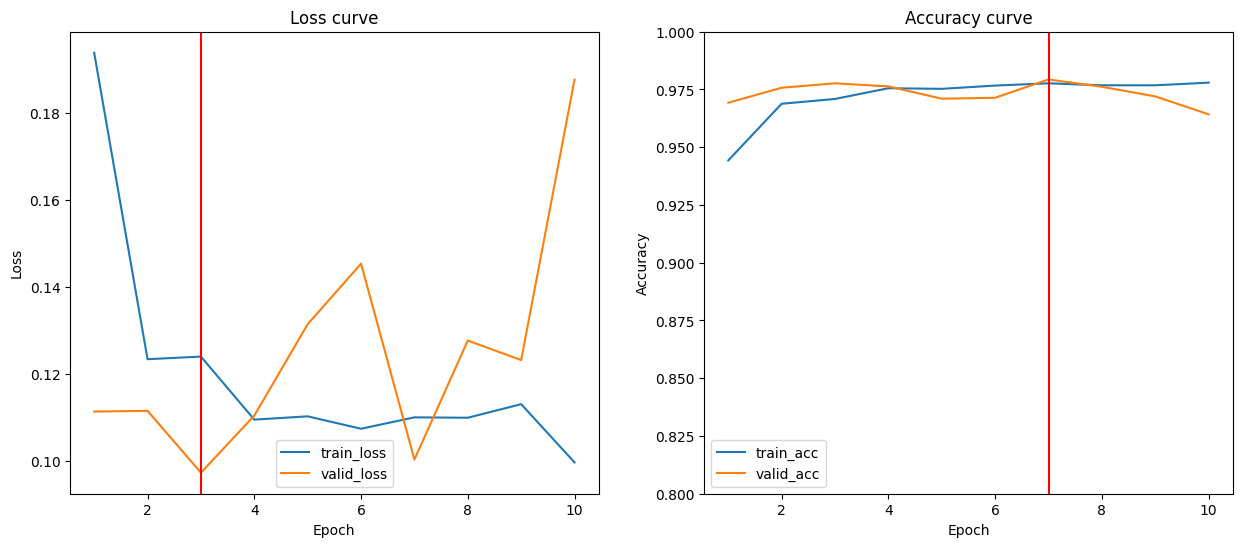

In [20]:
np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()

> Kernel Size = 15

In [21]:
batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 15)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


In [22]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)


In [23]:
n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch



In [24]:
# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

[1/10]
training loss : 0.435	 training accuracy : 0.862
validation loss : 0.302	 validation accuracy : 0.922
validation accuracy improved 0.00000 ======> 0.92217
[2/10]
training loss : 0.231	 training accuracy : 0.937
validation loss : 0.297	 validation accuracy : 0.923
validation accuracy improved 0.92217 ======> 0.92317
[3/10]
training loss : 0.210	 training accuracy : 0.944
validation loss : 0.197	 validation accuracy : 0.948
validation accuracy improved 0.92317 ======> 0.94800
[4/10]
training loss : 0.207	 training accuracy : 0.946
validation loss : 0.222	 validation accuracy : 0.946
[5/10]
training loss : 0.204	 training accuracy : 0.949
validation loss : 0.229	 validation accuracy : 0.940
[6/10]
training loss : 0.180	 training accuracy : 0.955
validation loss : 0.222	 validation accuracy : 0.946
[7/10]
training loss : 0.190	 training accuracy : 0.954
validation loss : 0.185	 validation accuracy : 0.955
validation accuracy improved 0.94800 ======> 0.95508
[8/10]
training loss : 0.

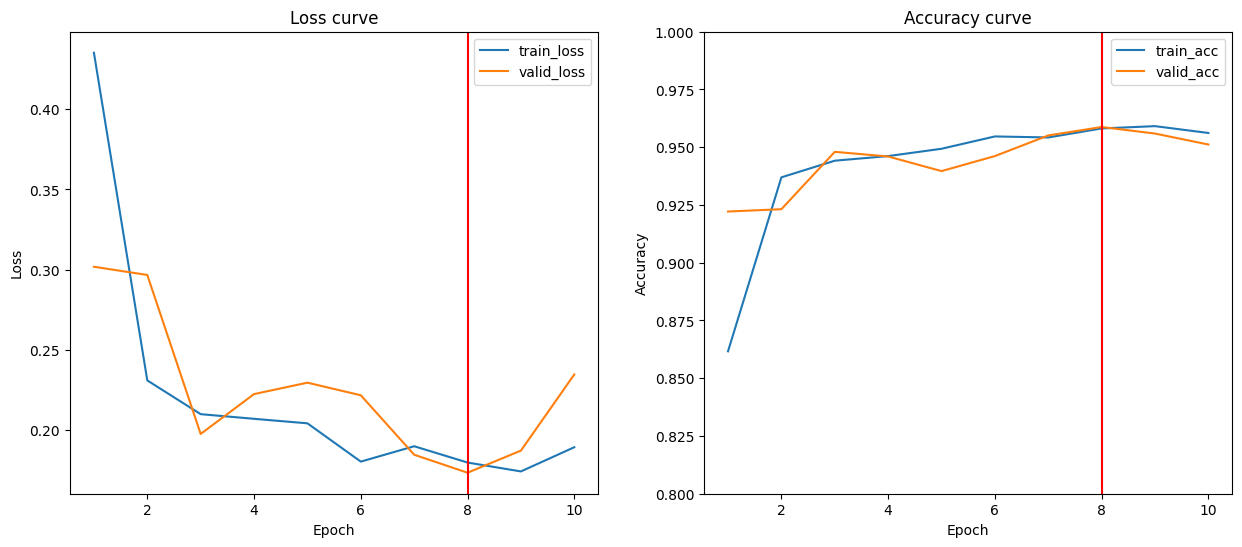

In [25]:
np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()

**2) [3 pts] replace all max pooling layers to average pooling layers(nn.AvgPool2d) in the program.
Compare the results.**

In [33]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.sigmoid(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 6)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


In [35]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)


In [36]:
n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch



In [37]:
# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

[1/10]
training loss : 0.557	 training accuracy : 0.798
validation loss : 0.096	 validation accuracy : 0.970
validation accuracy improved 0.00000 ======> 0.97033
[2/10]
training loss : 0.085	 training accuracy : 0.976
validation loss : 0.068	 validation accuracy : 0.980
validation accuracy improved 0.97033 ======> 0.98017
[3/10]
training loss : 0.063	 training accuracy : 0.981
validation loss : 0.067	 validation accuracy : 0.981
validation accuracy improved 0.98017 ======> 0.98117
[4/10]
training loss : 0.051	 training accuracy : 0.985
validation loss : 0.062	 validation accuracy : 0.982
validation accuracy improved 0.98117 ======> 0.98158
[5/10]
training loss : 0.041	 training accuracy : 0.988
validation loss : 0.058	 validation accuracy : 0.984
validation accuracy improved 0.98158 ======> 0.98400
[6/10]
training loss : 0.037	 training accuracy : 0.988
validation loss : 0.058	 validation accuracy : 0.984
[7/10]
training loss : 0.031	 training accuracy : 0.991
validation loss : 0.058	 

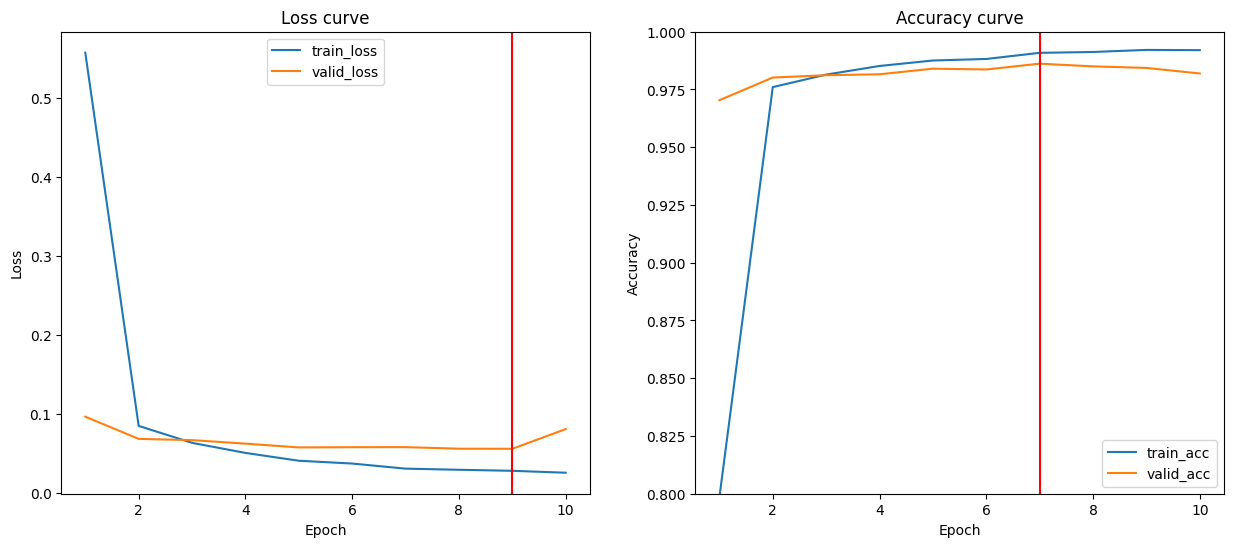

In [38]:
np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()

**3) [3 pts] change the current activation function to other non-linear activation function (e.g. sigmoid,
tanh, etc). You can do so by F.Sigmoid() to F.relu(), F.tanh(), etc. Repeat this three times and
compare the results.**

> Sigmoid

[1/10]
training loss : 0.556	 training accuracy : 0.800
validation loss : 0.143	 validation accuracy : 0.958
validation accuracy improved 0.00000 ======> 0.95833
[2/10]
training loss : 0.120	 training accuracy : 0.964
validation loss : 0.139	 validation accuracy : 0.958
[3/10]
training loss : 0.092	 training accuracy : 0.973
validation loss : 0.076	 validation accuracy : 0.977
validation accuracy improved 0.95833 ======> 0.97658
[4/10]
training loss : 0.076	 training accuracy : 0.977
validation loss : 0.087	 validation accuracy : 0.975
[5/10]
training loss : 0.066	 training accuracy : 0.981
validation loss : 0.092	 validation accuracy : 0.975
[6/10]
training loss : 0.064	 training accuracy : 0.981
validation loss : 0.078	 validation accuracy : 0.978
validation accuracy improved 0.97658 ======> 0.97792
[7/10]
training loss : 0.056	 training accuracy : 0.983
validation loss : 0.076	 validation accuracy : 0.978
[8/10]
training loss : 0.053	 training accuracy : 0.985
validation loss : 0.09

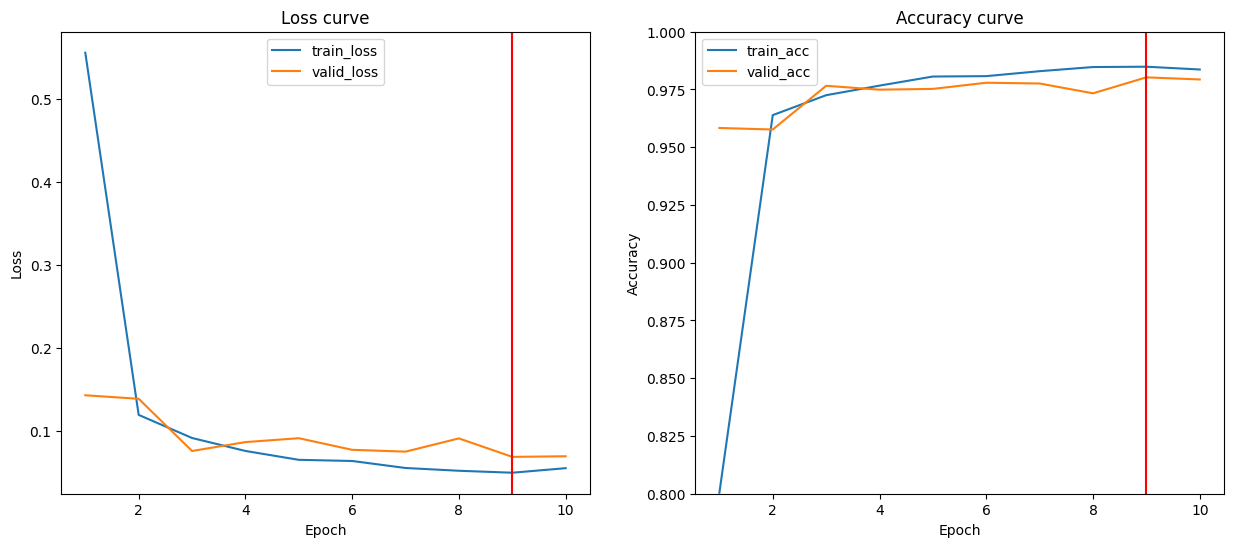

In [39]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.sigmool1(x)
        x = F.sigmoid(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


> Tanh

[1/10]
training loss : 0.278	 training accuracy : 0.915
validation loss : 0.280	 validation accuracy : 0.913
validation accuracy improved 0.00000 ======> 0.91325
[2/10]
training loss : 0.258	 training accuracy : 0.921
validation loss : 0.210	 validation accuracy : 0.939
validation accuracy improved 0.91325 ======> 0.93867
[3/10]
training loss : 0.240	 training accuracy : 0.928
validation loss : 0.346	 validation accuracy : 0.890
[4/10]
training loss : 0.252	 training accuracy : 0.925
validation loss : 0.252	 validation accuracy : 0.924
[5/10]
training loss : 0.249	 training accuracy : 0.925
validation loss : 0.244	 validation accuracy : 0.927
[6/10]
training loss : 0.246	 training accuracy : 0.925
validation loss : 0.347	 validation accuracy : 0.891
[7/10]
training loss : 0.244	 training accuracy : 0.925
validation loss : 0.247	 validation accuracy : 0.923
[8/10]
training loss : 0.247	 training accuracy : 0.926
validation loss : 0.244	 validation accuracy : 0.930
[9/10]
training loss :

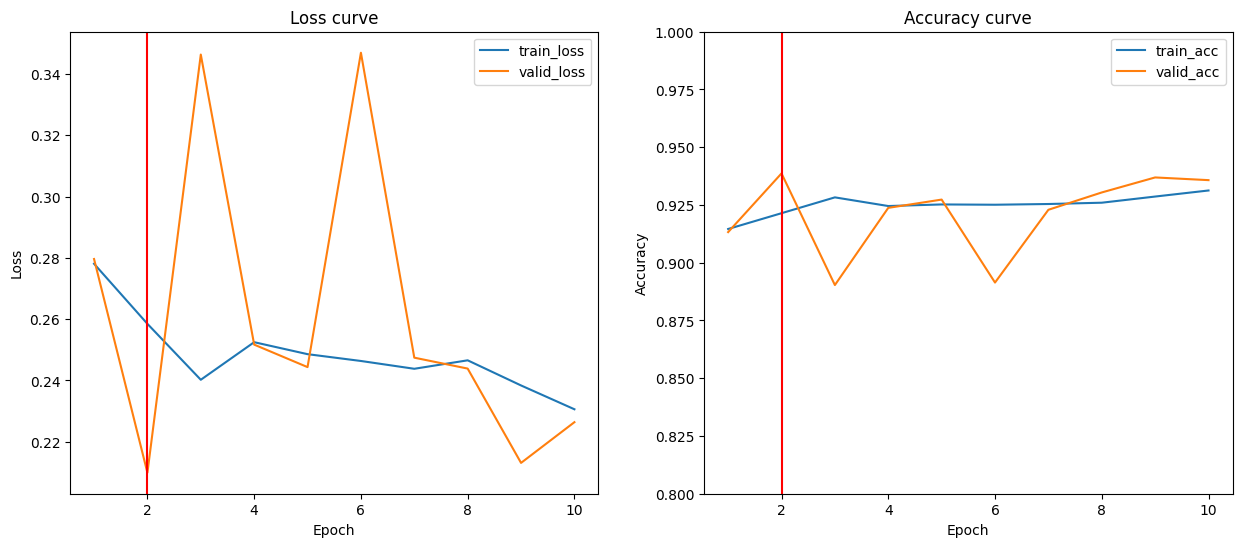

In [40]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.tanh(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.tanh(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


> Leaky Relu

[1/10]
training loss : 0.229	 training accuracy : 0.934
validation loss : 0.135	 validation accuracy : 0.966
validation accuracy improved 0.00000 ======> 0.96617
[2/10]
training loss : 0.156	 training accuracy : 0.962
validation loss : 0.166	 validation accuracy : 0.964
[3/10]
training loss : 0.217	 training accuracy : 0.952
validation loss : 0.073	 validation accuracy : 0.980
validation accuracy improved 0.96617 ======> 0.97950
[4/10]
training loss : 0.090	 training accuracy : 0.976
validation loss : 0.097	 validation accuracy : 0.977
[5/10]
training loss : 1.103	 training accuracy : 0.899
validation loss : 0.262	 validation accuracy : 0.924
[6/10]
training loss : 0.231	 training accuracy : 0.941
validation loss : 0.240	 validation accuracy : 0.941
[7/10]
training loss : 0.200	 training accuracy : 0.950
validation loss : 0.171	 validation accuracy : 0.964
[8/10]
training loss : 0.476	 training accuracy : 0.914
validation loss : 0.318	 validation accuracy : 0.897
[9/10]
training loss :

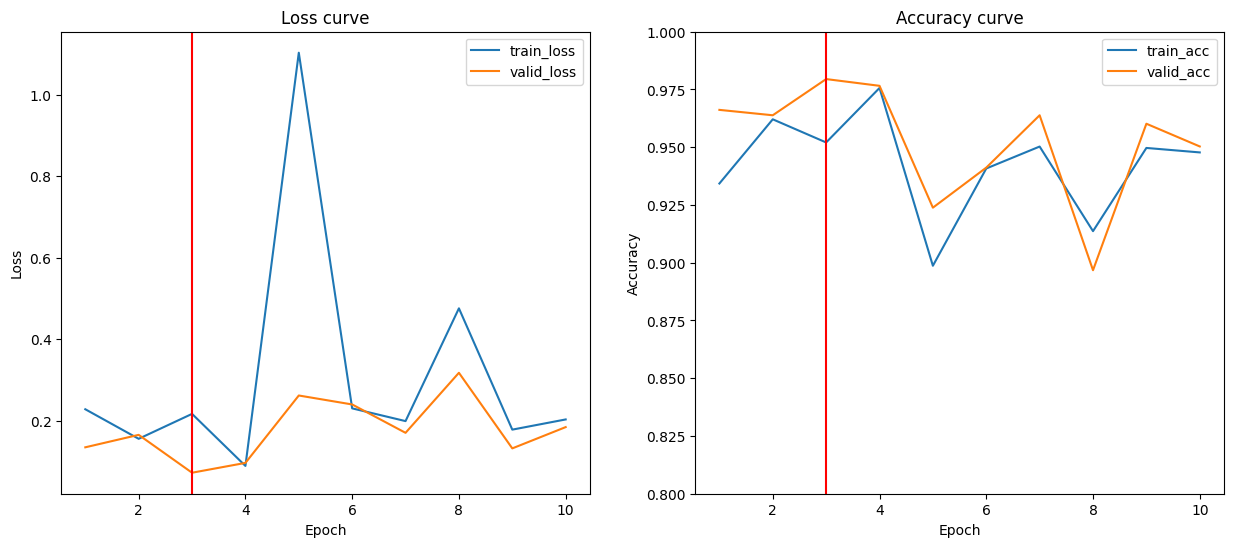

In [41]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.leaky_relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


**4) [3 pts] Add dropout layers to the fully connected layer and compare the results. (set
dropout_rate=0.25) Refer to the following site.**

[1/10]
training loss : 0.446	 training accuracy : 0.849
validation loss : 0.197	 validation accuracy : 0.943
validation accuracy improved 0.00000 ======> 0.94333
[2/10]
training loss : 0.182	 training accuracy : 0.950
validation loss : 0.153	 validation accuracy : 0.957
validation accuracy improved 0.94333 ======> 0.95650
[3/10]
training loss : 0.165	 training accuracy : 0.955
validation loss : 0.135	 validation accuracy : 0.961
validation accuracy improved 0.95650 ======> 0.96125
[4/10]
training loss : 0.156	 training accuracy : 0.958
validation loss : 0.161	 validation accuracy : 0.959
[5/10]
training loss : 0.148	 training accuracy : 0.962
validation loss : 0.161	 validation accuracy : 0.959
[6/10]
training loss : 0.148	 training accuracy : 0.963
validation loss : 0.185	 validation accuracy : 0.956
[7/10]
training loss : 0.131	 training accuracy : 0.968
validation loss : 0.146	 validation accuracy : 0.965
validation accuracy improved 0.96125 ======> 0.96450
[8/10]
training loss : 0.

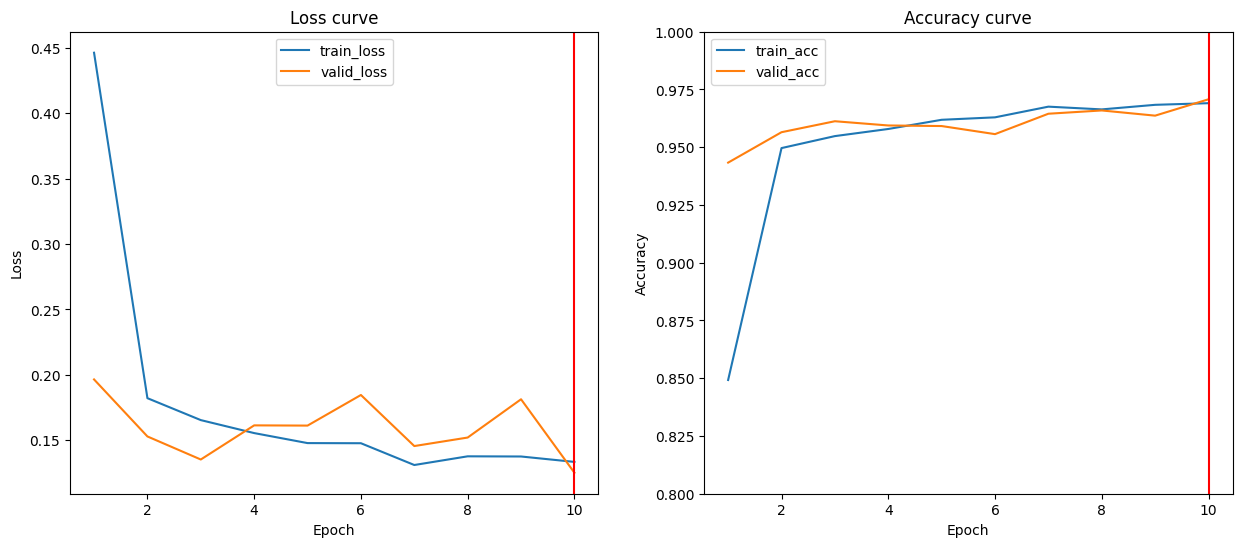

In [42]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


**5) [3 pts] change the current optimization method to other optimization methods (e.g. adam,
adaGrad, RMSProp, adaDelta, etc). You can use torch.optim.Adam, etc. Repeat this three times
and compare the results.**

> AdaGrad

[1/10]
training loss : 0.178	 training accuracy : 0.944
validation loss : 0.084	 validation accuracy : 0.973
validation accuracy improved 0.00000 ======> 0.97333
[2/10]
training loss : 0.068	 training accuracy : 0.980
validation loss : 0.066	 validation accuracy : 0.978
validation accuracy improved 0.97333 ======> 0.97825
[3/10]
training loss : 0.053	 training accuracy : 0.983
validation loss : 0.060	 validation accuracy : 0.980
validation accuracy improved 0.97825 ======> 0.98042
[4/10]
training loss : 0.045	 training accuracy : 0.986
validation loss : 0.052	 validation accuracy : 0.983
validation accuracy improved 0.98042 ======> 0.98300
[5/10]
training loss : 0.039	 training accuracy : 0.988
validation loss : 0.050	 validation accuracy : 0.984
validation accuracy improved 0.98300 ======> 0.98408
[6/10]
training loss : 0.035	 training accuracy : 0.989
validation loss : 0.048	 validation accuracy : 0.985
validation accuracy improved 0.98408 ======> 0.98458
[7/10]
training loss : 0.031

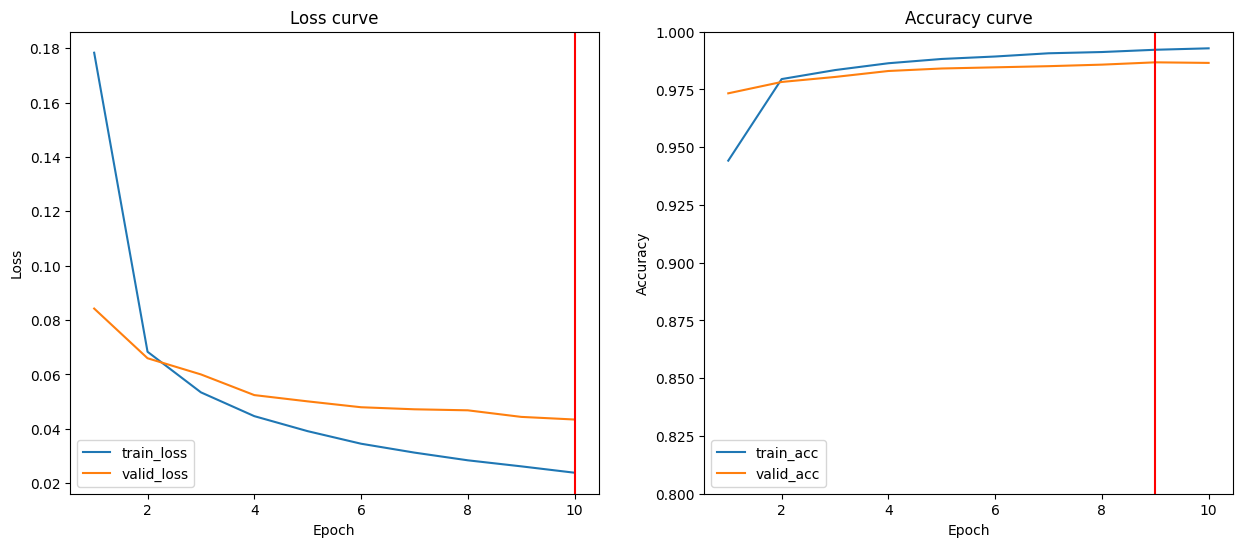

In [43]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


> RMSprop

[1/10]
training loss : 2.368	 training accuracy : 0.852
validation loss : 0.197	 validation accuracy : 0.945
validation accuracy improved 0.00000 ======> 0.94475
[2/10]
training loss : 0.175	 training accuracy : 0.953
validation loss : 0.157	 validation accuracy : 0.960
validation accuracy improved 0.94475 ======> 0.96033
[3/10]
training loss : 0.161	 training accuracy : 0.960
validation loss : 0.145	 validation accuracy : 0.965
validation accuracy improved 0.96033 ======> 0.96542
[4/10]
training loss : 0.159	 training accuracy : 0.962
validation loss : 0.148	 validation accuracy : 0.964
[5/10]
training loss : 0.150	 training accuracy : 0.966
validation loss : 0.175	 validation accuracy : 0.956
[6/10]
training loss : 0.150	 training accuracy : 0.968
validation loss : 0.147	 validation accuracy : 0.969
validation accuracy improved 0.96542 ======> 0.96850
[7/10]
training loss : 0.155	 training accuracy : 0.969
validation loss : 0.160	 validation accuracy : 0.973
validation accuracy impro

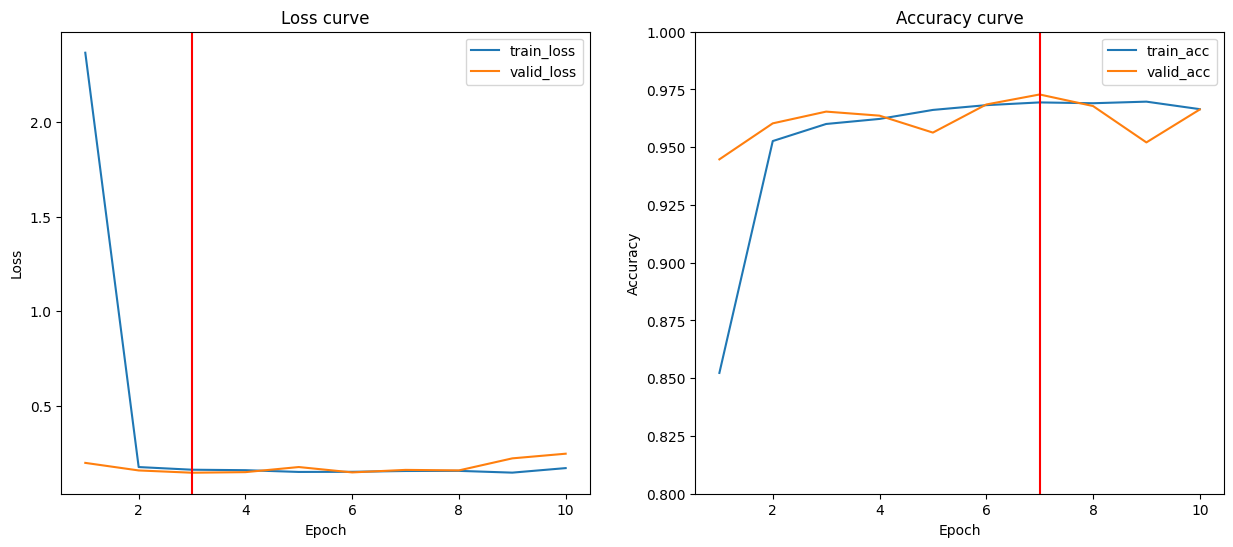

In [49]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32


n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


> SGD

[1/10]
training loss : 1.678	 training accuracy : 0.458
validation loss : 0.437	 validation accuracy : 0.864
validation accuracy improved 0.00000 ======> 0.86350
[2/10]
training loss : 0.291	 training accuracy : 0.909
validation loss : 0.235	 validation accuracy : 0.922
validation accuracy improved 0.86350 ======> 0.92217
[3/10]
training loss : 0.164	 training accuracy : 0.949
validation loss : 0.125	 validation accuracy : 0.961
validation accuracy improved 0.92217 ======> 0.96142
[4/10]
training loss : 0.116	 training accuracy : 0.965
validation loss : 0.126	 validation accuracy : 0.960
[5/10]
training loss : 0.091	 training accuracy : 0.972
validation loss : 0.095	 validation accuracy : 0.969
validation accuracy improved 0.96142 ======> 0.96875
[6/10]
training loss : 0.076	 training accuracy : 0.976
validation loss : 0.073	 validation accuracy : 0.975
validation accuracy improved 0.96875 ======> 0.97533
[7/10]
training loss : 0.065	 training accuracy : 0.979
validation loss : 0.071	 

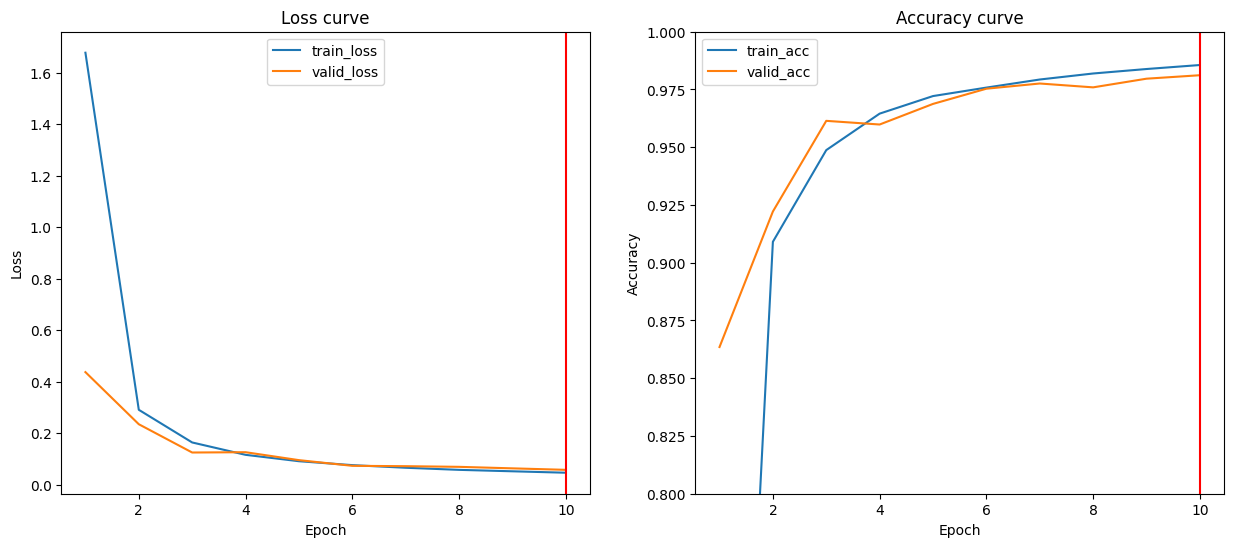

In [50]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


**6) [3 pts] now add the Xavier weight initialization method and compare the results. (use
torch.nn.init.xavier_uniform)**

<ipython-input-52-7fdbc8fe1df7>:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


[1/10]
training loss : 0.260	 training accuracy : 0.920
validation loss : 0.221	 validation accuracy : 0.940
validation accuracy improved 0.00000 ======> 0.94017
[2/10]
training loss : 0.170	 training accuracy : 0.954
validation loss : 0.133	 validation accuracy : 0.964
validation accuracy improved 0.94017 ======> 0.96408
[3/10]
training loss : 0.154	 training accuracy : 0.960
validation loss : 0.154	 validation accuracy : 0.959
[4/10]
training loss : 0.143	 training accuracy : 0.964
validation loss : 0.181	 validation accuracy : 0.958
[5/10]
training loss : 0.137	 training accuracy : 0.966
validation loss : 0.125	 validation accuracy : 0.968
validation accuracy improved 0.96408 ======> 0.96783
[6/10]
training loss : 0.140	 training accuracy : 0.967
validation loss : 0.152	 validation accuracy : 0.966
[7/10]
training loss : 0.132	 training accuracy : 0.968
validation loss : 0.151	 validation accuracy : 0.966
[8/10]
training loss : 0.135	 training accuracy : 0.969
validation loss : 0.13

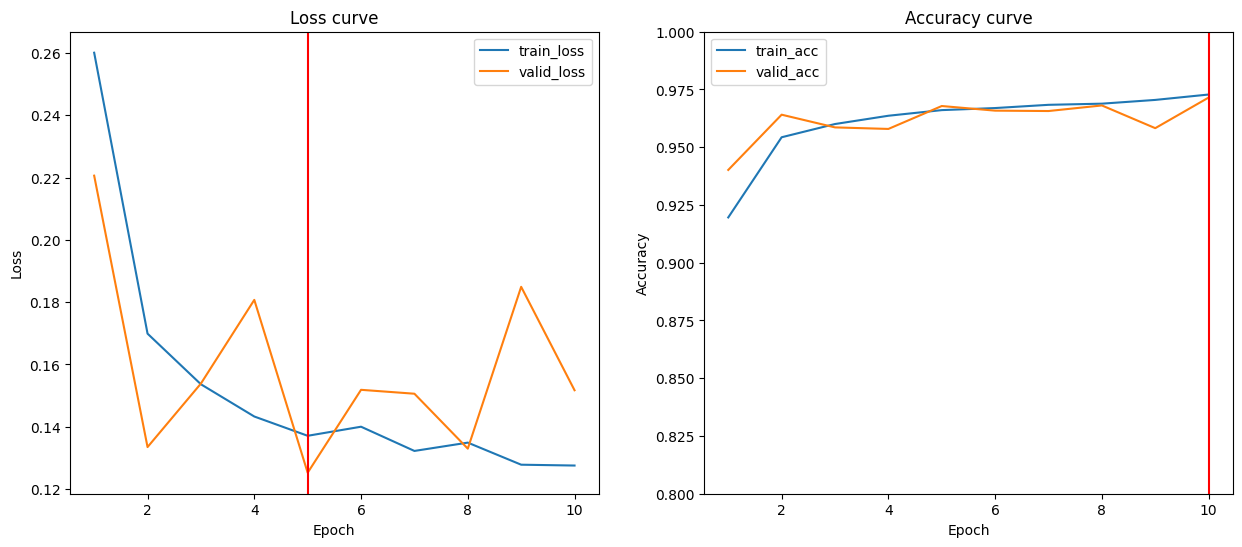

In [52]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32
n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


**7) [3 pts] choose Adam optimization method and use L2 (ridge) regularization method this time.
You can do so by setting ‘weight_decay’ value in optimization method (torch.optim.Adam) to a
tiny number (e.g. 1e-5). Compare the results of using regularization**

[1/10]
training loss : 2.302	 training accuracy : 0.103
validation loss : 2.303	 validation accuracy : 0.097
validation accuracy improved 0.00000 ======> 0.09683
[2/10]
training loss : 2.302	 training accuracy : 0.103
validation loss : 2.302	 validation accuracy : 0.101
validation accuracy improved 0.09683 ======> 0.10125
[3/10]
training loss : 2.302	 training accuracy : 0.104
validation loss : 2.303	 validation accuracy : 0.101
[4/10]
training loss : 2.302	 training accuracy : 0.103
validation loss : 2.302	 validation accuracy : 0.103
validation accuracy improved 0.10125 ======> 0.10300
[5/10]
training loss : 2.302	 training accuracy : 0.102
validation loss : 2.302	 validation accuracy : 0.101
[6/10]
training loss : 2.302	 training accuracy : 0.104
validation loss : 2.303	 validation accuracy : 0.101
[7/10]
training loss : 2.302	 training accuracy : 0.101
validation loss : 2.302	 validation accuracy : 0.103
[8/10]
training loss : 2.302	 training accuracy : 0.105
validation loss : 2.30

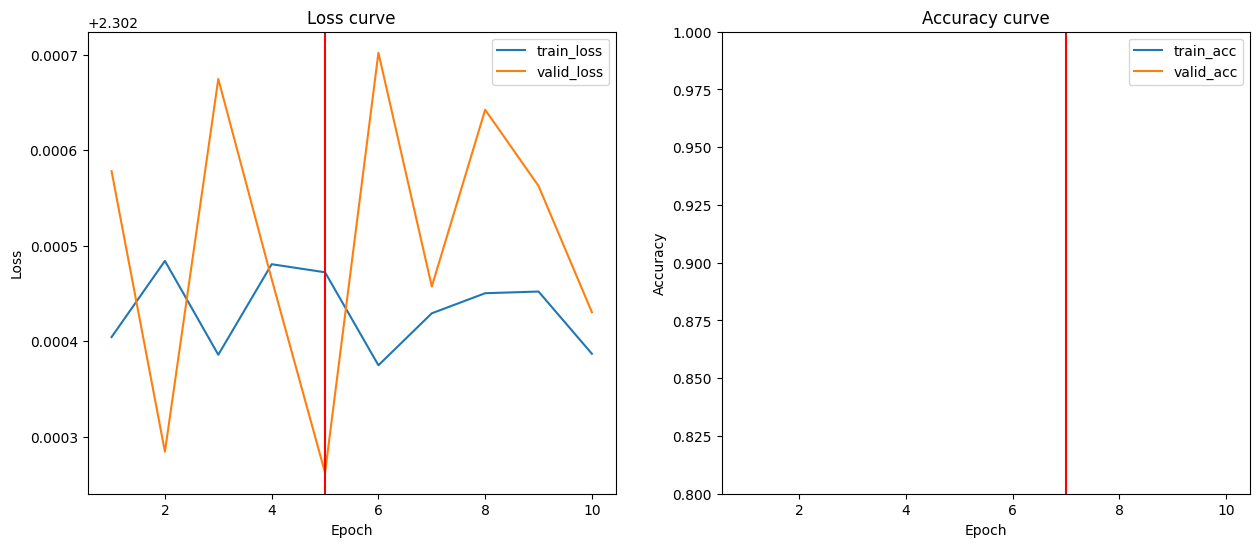

In [53]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(84, n_outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

batch_size = 32

n_epochs = 10
learning_rate = 0.01
model = CNN_1(1, 10, 8)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1**-5)
loss_function = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)



n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)



np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

np_acc = np.array(valid_acc)
acc_ind_sorted = np.argsort(np_acc)
acc_max_ind = acc_ind_sorted[-1]

x = [i+1 for i in range(len(train_loss))]


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(x, train_acc, label='train_acc')
plt.plot(x, valid_acc, label='valid_acc')
plt.axvline(acc_max_ind+1, color='red')
plt.ylim(0.8,1)
plt.legend()


model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))


# 2

In [54]:
batch_size = 32

train_data = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

test_data = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

train_data, valid_data = train_test_split(train_data, test_size=0.2, shuffle=True)
print('# of train data : {}'.format(len(train_data)))
print('# of valid data : {}'.format(len(valid_data)))
print('# of test data : {}'.format(len(test_data)))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# of train data : 48000
# of valid data : 12000
# of test data : 10000


In [55]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 64
n_outputs = 10

learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

import copy

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)


[1/10]
training loss : 0.262	 training accuracy : 0.930
validation loss : 0.185	 validation accuracy : 0.953
validation accuracy improved 0.00000 ======> 0.95325
[2/10]
training loss : 0.279	 training accuracy : 0.937
validation loss : 0.194	 validation accuracy : 0.947
[3/10]
training loss : 0.203	 training accuracy : 0.950
validation loss : 0.178	 validation accuracy : 0.954
validation accuracy improved 0.95325 ======> 0.95408
[4/10]
training loss : 0.155	 training accuracy : 0.958
validation loss : 0.170	 validation accuracy : 0.960
validation accuracy improved 0.95408 ======> 0.96033
[5/10]
training loss : 0.531	 training accuracy : 0.901
validation loss : 0.302	 validation accuracy : 0.928
[6/10]
training loss : 0.289	 training accuracy : 0.932
validation loss : 0.319	 validation accuracy : 0.928
[7/10]
training loss : 0.353	 training accuracy : 0.926
validation loss : 0.366	 validation accuracy : 0.931
[8/10]
training loss : 0.284	 training accuracy : 0.935
validation loss : 0.20

KeyboardInterrupt: 

**1) [3 pts] change the number of hidden layers in the program three times and compare the results.**

In [56]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 32
n_outputs = 10

learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

import copy

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



[1/10]
training loss : 0.210	 training accuracy : 0.941
validation loss : 0.122	 validation accuracy : 0.966
validation accuracy improved 0.00000 ======> 0.96583
[2/10]
training loss : 0.136	 training accuracy : 0.965
validation loss : 0.260	 validation accuracy : 0.937
[3/10]
training loss : 0.167	 training accuracy : 0.958
validation loss : 0.157	 validation accuracy : 0.958
[4/10]
training loss : 0.171	 training accuracy : 0.955
validation loss : 0.165	 validation accuracy : 0.952
[5/10]
training loss : 0.124	 training accuracy : 0.967
validation loss : 0.124	 validation accuracy : 0.966
validation accuracy improved 0.96583 ======> 0.96625
[6/10]
training loss : 0.120	 training accuracy : 0.968
validation loss : 0.135	 validation accuracy : 0.966
[7/10]
training loss : 0.134	 training accuracy : 0.963
validation loss : 0.128	 validation accuracy : 0.963
[8/10]
training loss : 0.107	 training accuracy : 0.970
validation loss : 0.130	 validation accuracy : 0.964
[9/10]
training loss :

In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 16
n_outputs = 10

learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

import copy

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



[1/10]
training loss : 0.203	 training accuracy : 0.936
validation loss : 0.107	 validation accuracy : 0.967
validation accuracy improved 0.00000 ======> 0.96675
[2/10]
training loss : 0.102	 training accuracy : 0.971
validation loss : 0.096	 validation accuracy : 0.971
validation accuracy improved 0.96675 ======> 0.97075
[3/10]
training loss : 0.098	 training accuracy : 0.971
validation loss : 0.113	 validation accuracy : 0.968
[4/10]
training loss : 0.086	 training accuracy : 0.975
validation loss : 0.092	 validation accuracy : 0.973
validation accuracy improved 0.97075 ======> 0.97300
[5/10]
training loss : 0.086	 training accuracy : 0.975
validation loss : 0.092	 validation accuracy : 0.974
validation accuracy improved 0.97300 ======> 0.97358


In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 128
n_outputs = 10

learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



**2) [3 pts] change the current optimization method to other optimization methods (e.g. adam,
adaGrad, RMSProp, adaDelta, etc). Repeat this three times and compare the results.**

> SGD

In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 64
n_outputs = 10

learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

import copy

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



> Adagrad

In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 64
n_outputs = 10

learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

import copy

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



> RMSProp

In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 64
n_outputs = 10

learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

import copy

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



**3) [3 pts] change LSTM to GRU (or vice versa). Compare the results.**


In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 64
n_outputs = 10

learning_rate = 0.01

model = LSTM(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

import copy

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



**4) [3 pts] choose ONE other parameters of RNN program (e.g. batch_size, epochs, etc). Change
the value of this parameter and compare the results.**


In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 64
n_outputs = 10


learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


n_epochs = 15

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



**5) [3 pts] compare the accuracy of RNN for Mnist with that of CNN.**

 MNIST is an image dataset. CNN is considered to be the best for image classification due to it adaptibility to salient features like edges and shapes. For this reason, CNN outperforms RNN.

**6) [3 pts] choose Adam optimization method and use L2 (ridge) regularization method this time.
You can do so by setting ‘weight_decay’ value in optimization method to a tiny number (e.g. 1e-
5). Compare the results of using regularization**

In [ ]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_outputs, sequence_len):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_len, n_outputs)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.gru(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

input_size = 28
sequence_len = 28
num_layers = 2
hidden_size = 64
n_outputs = 10

learning_rate = 0.01

model = GRU(input_size, hidden_size, num_layers, n_outputs, sequence_len)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1**-5)
loss_function = nn.CrossEntropyLoss()

import copy

n_epochs = 10

train_loss = [] # train loss per epoch
valid_loss = [] # valid loss per epoch

train_acc = [] # train accuracy per epoch
valid_acc = [] # valid accuracy per epoch

# update following two variables whenever valid accuracy improves
best_acc = 0
best_model = copy.deepcopy(model)

for epoch in range(n_epochs):
    model.train() # set model as training mode(for compute gradient)
    train_total = 0
    train_correct = 0
    epoch_train_loss = 0
    for i, data in enumerate(train_loader):
        # In PyTorch, for every mini-batch during the training phase, we have to explicitly
        # set the gradients to zero before starting to do backpropragation with following code
        optimizer.zero_grad()

        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loss = loss_function(outputs, labels)
        epoch_train_loss += loss.item()

        loss.backward() # compute gradient
        optimizer.step() # update weight & bias in the model with computed gradient

    train_loss.append(epoch_train_loss/len(train_loader))
    train_acc.append(train_correct/train_total)

    model.eval() # set model as evaluation mode
    with torch.no_grad():# we don't need to compute gradient during the evaluation process
        valid_total = 0
        valid_correct = 0
        epoch_valid_loss = 0
        for data in valid_loader:
            inputs, labels = data[0], data[1]
            outputs = model(inputs.squeeze(1))

            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

            loss = loss_function(outputs, labels)
            epoch_valid_loss += loss.item()

        valid_loss.append(epoch_valid_loss/len(valid_loader))
        valid_acc.append(valid_correct / valid_total)

    print('[{}/{}]'.format(epoch+1, n_epochs))
    print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
    print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))

    if valid_correct/valid_total > best_acc:
        print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
        best_acc = valid_correct/valid_total
        best_model = copy.deepcopy(model)

model.eval()
with torch.no_grad():
    test_total = 0
    test_correct = 0
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = model(inputs.squeeze(1))

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total
    print('test accuracy : {:.3f}'.format(test_acc))



# Extra Credit

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




**1) [3 pts] change the current kernel size of the program to different size. (Change ‘kernel_size’
parameter of ‘Conv2D’ function.) Repeat this three times and compare the results.**

**2) [3 pts] replace all max pooling layers to average pooling layers(nn.AvgPool2d) in the program.
Compare the results.**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




**3) [3 pts] change the current activation function to other non-linear activation function (e.g. sigmoid,
tanh, etc). You can do so by F.Sigmoid() to F.relu(), F.tanh(), etc. Repeat this three times and
compare the results.**

> Sigmoid

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




> Tanh

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




> Leaky Relu

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




**4) [3 pts] Add dropout layers to the fully connected layer and compare the results. (set
dropout_rate=0.25) Refer to the following site.**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.25)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




**5) [3 pts] change the current optimization method to other optimization methods (e.g. adam,
adaGrad, RMSProp, adaDelta, etc). You can use torch.optim.Adam, etc. Repeat this three times
and compare the results.**

> AdaGrad

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.001)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




> RMSprop

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




> Adam

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




**6) [3 pts] now add the Xavier weight initialization method and compare the results. (use
torch.nn.init.xavier_uniform)**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




**7) [3 pts] choose Adam optimization method and use L2 (ridge) regularization method this time.
You can do so by setting ‘weight_decay’ value in optimization method (torch.optim.Adam) to a
tiny number (e.g. 1e-5). Compare the results of using regularization**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 1**-5)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


